In [1]:
# %%
import numpy as np
import pandas as pd
import sys
import os
import re
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [2]:

# Добавляем путь к нашей песочнице если нужно
current_dir = os.getcwd()  # путь к notebooks
optimization_path = r"src"
if optimization_path not in sys.path:
    sys.path.append(optimization_path)

In [3]:
from src.spore_tree_config import SporeTreeConfig
from src.spore_tree import SporeTree
from src.pendulum import PendulumSystem
from src.visualize_spore_tree import visualize_spore_tree
from src.area_opt.tree_area_evaluator import TreeAreaEvaluator

In [4]:
from src.pairs.time_profiler import StageProfiler
from src.pairs.find_optimal_pairs_profiled import find_optimal_pairs_profiled

from src.area_opt.get_tree_area import get_tree_area
from src.area_opt.create_distance_constraints import create_distance_constraints, test_constraints
from src.area_opt.optimize_tree_area import optimize_tree_area

from src.pairs.complete_meeting_analysis import complete_meeting_analysis
from src.pairs.create_chronological_meetings import create_chronological_meetings
from src.pairs.optimize_grandchild_parent_distance import optimize_grandchild_parent_distance
from src.pairs.optimize_grandchild_pair_distance import optimize_grandchild_pair_distance
from src.pairs.find_optimal_pairs import find_optimal_pairs
from src.pairs.extract_optimal_times_from_pairs import extract_optimal_times_from_pairs
from src.pairs.create_tree_from_pairs import create_tree_from_pairs


from src.pairs.extract_pairs_from_chronology import (
    extract_pairs_from_chronology,
    get_pair_details,
    analyze_pair_statistics,
    export_pairs_to_csv
)
from src.pairs.create_meeting_chronology import (
    create_meeting_chronology,
    export_chronology_to_csv,
    get_meeting_recommendations
)
from src.pairs.build_distance_tables import (
    build_grandchild_distance_tables,
    build_grandchild_parent_distance_tables
)
from src.pairs.compute_convergence_tables import (
    compute_distance_derivative_table,
    compute_grandchild_parent_convergence_table
)
from src.pairs.find_converging_pairs import (
    find_converging_grandchild_pairs,
    find_converging_grandchild_parent_pairs
)
from src.pairs.extract_optimal_dt_from_pairs import (
    extract_optimal_dt_from_pairs,
    create_optimized_tree_from_pairs,
    compare_trees_distances
)

In [5]:
def draw_rk(pendulum, state, control, N = 50, total_dt=0.01, show=False):
    poses = [state]
    dt = total_dt/N
    for i in range(1, N+1):
        poses.append(pendulum.step(poses[-1], control, dt))

    return np.array(poses)

In [6]:
pendulum = PendulumSystem(
    g=9.81,
    l=2.0, 
    m=1.0,
    damping=0.05,
    max_control=2.0
)

init_position = np.array([np.pi/2 , 0])

cfg = SporeTreeConfig(
    initial_position=init_position,
    dt_base=0.1,
    dt_grandchildren_factor=0.5,
    figure_size=(10, 15)
)
cfg.validate()

True

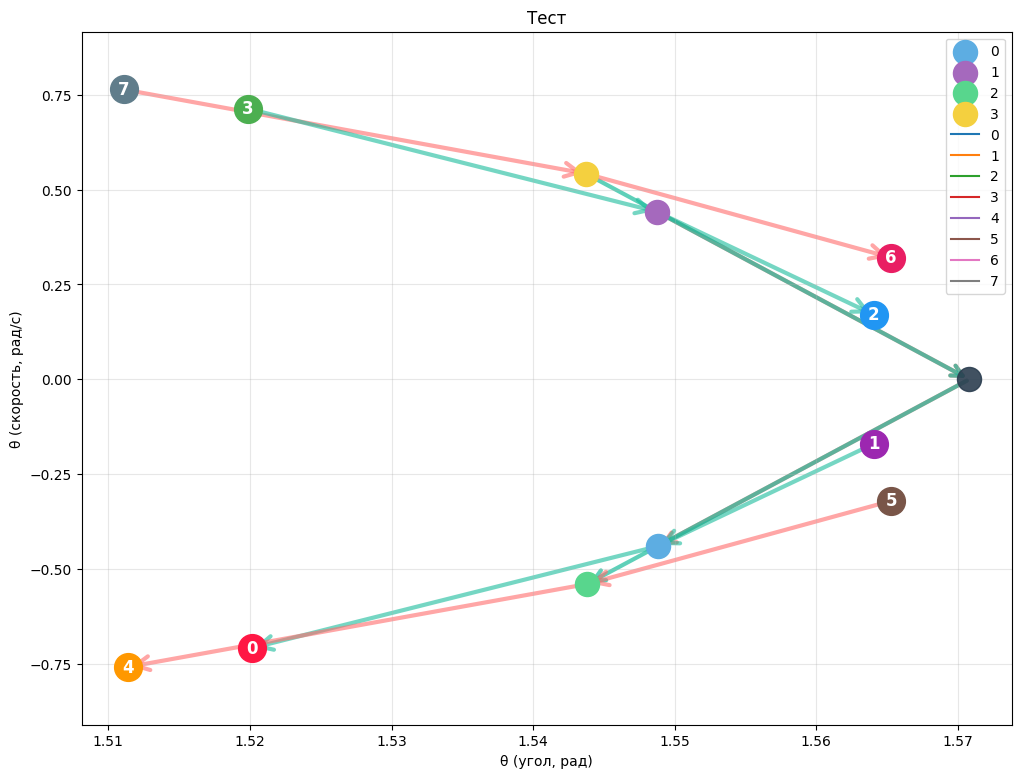

In [7]:
tree = SporeTree(pendulum, cfg)
children = tree.create_children(show=False)
grandchildren = tree.create_grandchildren(show=False)
tree.sort_and_pair_grandchildren()
tree.calculate_mean_points()

# ──────────────────────────────────────────────────────────────────────
# 2. Кэш-оценщик на основе дерева
# ──────────────────────────────────────────────────────────────────────
visualize_spore_tree(tree, "Тест")


poses = []
# dts = [0.01, 0.005, 0.003, 0.003, 0.01, 0.006, 0.003, 0.003]
dts = [1.5, -0.07897676, 0.07897674, -0.9, 0.00, 0.00, 0.00, 0.000] 
dts = np.array(dts) *0

for i in range(len(grandchildren)):
    parent_pos = children[grandchildren[i]['parent_idx']]['position']
    sign = grandchildren[i]['dt'] / grandchildren[i]['dt_abs']
    control = grandchildren[i]['control']
    poses_1 = draw_rk(pendulum, state=parent_pos, control=control, total_dt=dts[i])

    plt.plot(poses_1[:, 0], poses_1[:, 1], label=f'{i}')

plt.legend()


Создано дерево с 4 парами


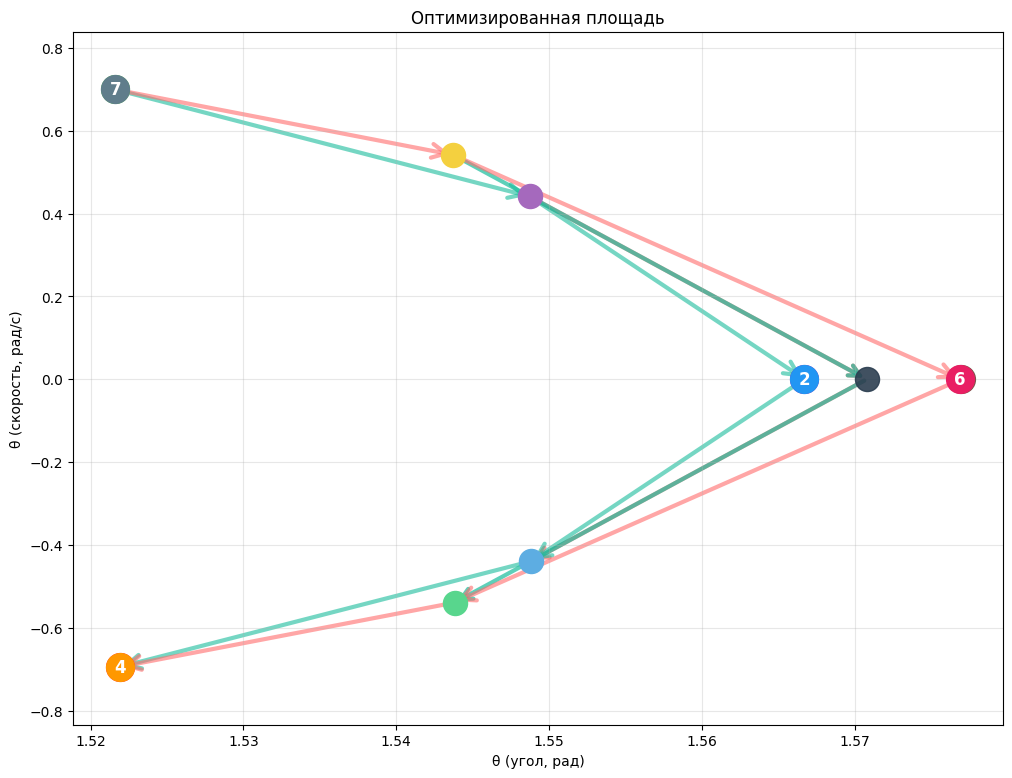

In [8]:
pairs = find_optimal_pairs(tree, show=False)
# Полный дебаг
result = create_tree_from_pairs(tree, pendulum, cfg, show=False)

# Проверка результата
if result and result['success']:
    paired_tree = result['optimized_tree']
    print(f"Создано дерево с {result['stats']['pairs_found']} парами")
else:
    print(f"Ошибка: {result['error'] if result else 'критическая ошибка'}")

visualize_spore_tree(paired_tree, "Оптимизированная площадь")

In [18]:
print([child['dt'] for child in paired_tree.children])
print([np.round(grandchild['dt'], 3) for grandchild in paired_tree.grandchildren])

[0.1, -0.1, 0.1, -0.1]
[0.047, -0.081, 0.081, -0.048, 0.036, -0.123, 0.123, -0.036]


In [19]:
print([child['dt'] for child in optimized_tree.children])
print([np.round(grandchild['dt'], 3) for grandchild in optimized_tree.grandchildren])

[0.09999884743677508, -0.1, 0.08117357068211375, -0.08183897574382014]
[0.034, -0.1, 0.063, -0.035, 0.042, -0.1, 0.1, -0.042]


In [9]:
get_tree_area(paired_tree)

0.01903093149412921

0.11537239800373744


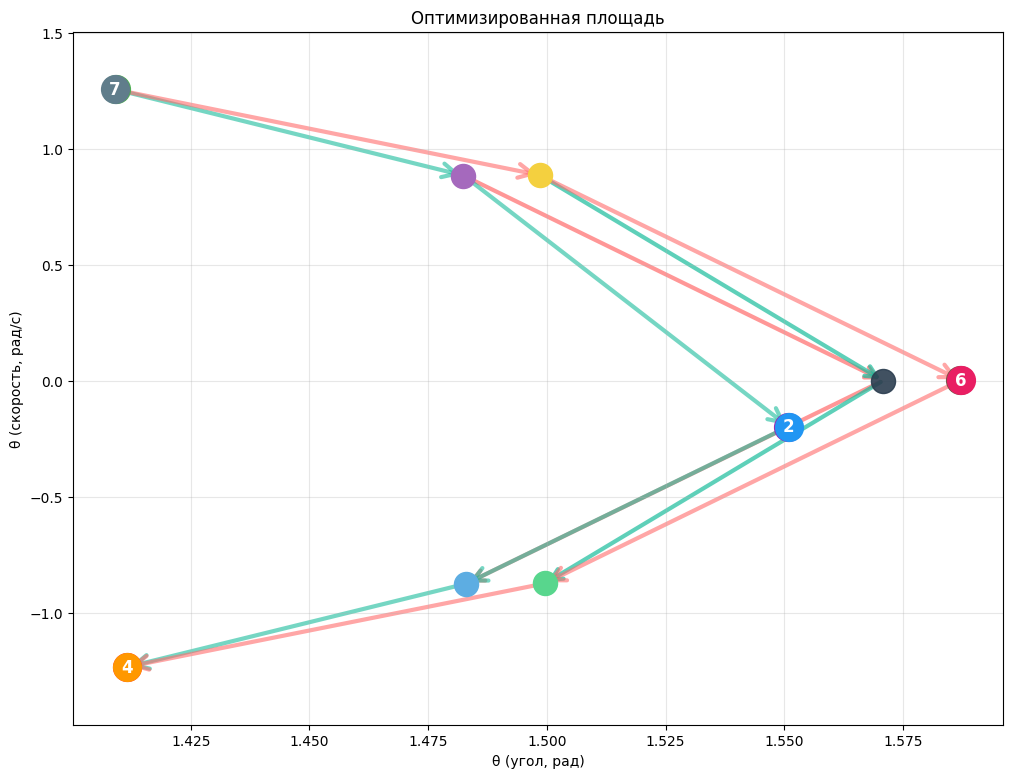

In [21]:
result = optimize_tree_area(
            tree=paired_tree,
            pairs=pairs, 
            optimization_method='SLSQP',
            pendulum=pendulum,
            constraint_distance=1e-4,  # Максимальное расстояние между парами
            max_iterations=1500,
            dt_bounds=(0.001, 0.2),
            show=False  # Показать весь процесс
        )

if result['success']:
    optimized_tree = result['optimized_tree']
    print(get_tree_area(optimized_tree))
    visualize_spore_tree(optimized_tree, "Оптимизированная площадь")
else:
    print(f"Ошибка: {result}")

In [11]:
# %%
# СРАВНЕНИЕ ДИСТАНЦИЙ ПАР В ДВУХ ДЕРЕВЬЯХ
print("СРАВНЕНИЕ ДИСТАНЦИЙ ПАР В ДВУХ ДЕРЕВЬЯХ")
print("=" * 60)

import numpy as np

# Проверяем что есть все нужные переменные
if 'pairs' not in locals():
    print("Ошибка: переменная 'pairs' не найдена")
elif 'paired_tree' not in locals():
    print("Ошибка: переменная 'paired_tree' не найдена")
elif 'optimized_tree' not in locals():
    print("Ошибка: переменная 'optimized_tree' не найдена")
else:
    # Вычисляем constraint'ы
    parent_distances = [np.linalg.norm(parent['position'] - paired_tree.root['position']) 
                       for parent in paired_tree.children]
    original_constraint = min(parent_distances) / 10.0
    area_optimization_constraint = 1e-4  # Из optimize_tree_area
    
    print(f"Исходный constraint (поиск пар): {original_constraint:.6f}")
    print(f"Constraint оптимизации площади: {area_optimization_constraint:.6f}")
    print(f"Количество пар для проверки: {len(pairs)}")
    print()
    
    # Проверяем каждую пару в обоих деревьях
    paired_distances = []
    optimized_distances = []
    
    for i, (gc_i_idx, gc_j_idx, meeting_info) in enumerate(pairs):
        # Дистанции в paired_tree
        gc_i_pos_paired = paired_tree.grandchildren[gc_i_idx]['position']
        gc_j_pos_paired = paired_tree.grandchildren[gc_j_idx]['position']
        dist_paired = np.linalg.norm(gc_i_pos_paired - gc_j_pos_paired)
        paired_distances.append(dist_paired)
        
        # Дистанции в optimized_tree
        gc_i_pos_opt = optimized_tree.grandchildren[gc_i_idx]['position']
        gc_j_pos_opt = optimized_tree.grandchildren[gc_j_idx]['position']
        dist_opt = np.linalg.norm(gc_i_pos_opt - gc_j_pos_opt)
        optimized_distances.append(dist_opt)
        
        # Проверка constraint'ов
        passes_original_paired = dist_paired <= original_constraint
        passes_original_opt = dist_opt <= original_constraint
        passes_area_paired = dist_paired <= area_optimization_constraint
        passes_area_opt = dist_opt <= area_optimization_constraint
        
        # Направления времени для информации
        gc_i = paired_tree.grandchildren[gc_i_idx]
        gc_j = paired_tree.grandchildren[gc_j_idx]
        direction_i = "F" if gc_i['dt'] > 0 else "B"
        direction_j = "F" if gc_j['dt'] > 0 else "B"
        
        print(f"Пара {i+1}: gc_{gc_i_idx}({direction_i}) ↔ gc_{gc_j_idx}({direction_j})")
        print(f"  Paired tree:    {dist_paired:.6f} (исходный: {'✅' if passes_original_paired else '❌'}, площадь: {'✅' if passes_area_paired else '❌'})")
        print(f"  Optimized tree: {dist_opt:.6f} (исходный: {'✅' if passes_original_opt else '❌'}, площадь: {'✅' if passes_area_opt else '❌'})")
        
        # Изменение дистанции
        change = dist_opt - dist_paired
        if abs(change) > 1e-6:
            change_str = f"({change:+.6f})"
            if change > 0:
                change_str += " ХУЖЕ"
            else:
                change_str += " ЛУЧШЕ"
            print(f"  Изменение: {change_str}")
        print()
    
    # Статистика по constraint'ам
    def check_constraints(distances, constraint_name, constraint_value):
        passing = sum(1 for d in distances if d <= constraint_value)
        print(f"{constraint_name}: {passing}/{len(distances)} пар проходят")
        return passing
    
    print("СТАТИСТИКА ПО CONSTRAINT'АМ:")
    print("-" * 30)
    
    print("PAIRED TREE:")
    paired_original_pass = check_constraints(paired_distances, "  Исходный constraint", original_constraint)
    paired_area_pass = check_constraints(paired_distances, "  Площадь constraint", area_optimization_constraint)
    
    print("OPTIMIZED TREE:")
    opt_original_pass = check_constraints(optimized_distances, "  Исходный constraint", original_constraint)
    opt_area_pass = check_constraints(optimized_distances, "  Площадь constraint", area_optimization_constraint)
    
    # Общая статистика
    print("\nОБЩАЯ СТАТИСТИКА:")
    print("-" * 20)
    print(f"Paired tree - среднее расстояние: {np.mean(paired_distances):.6f}")
    print(f"Optimized tree - среднее расстояние: {np.mean(optimized_distances):.6f}")
    
    avg_change = np.mean(np.array(optimized_distances) - np.array(paired_distances))
    print(f"Среднее изменение: {avg_change:+.6f}")
    
    # Итоговый вывод
    print("\nВЫВОД:")
    if opt_area_pass == len(pairs):
        print("✅ Все пары в optimized_tree соответствуют constraint'у оптимизации площади")
    elif opt_area_pass > paired_area_pass:
        print(f"📈 Optimized_tree лучше: {opt_area_pass} vs {paired_area_pass} пар проходят area constraint")
    elif opt_area_pass < paired_area_pass:
        print(f"📉 Optimized_tree хуже: {opt_area_pass} vs {paired_area_pass} пар проходят area constraint")
    else:
        print("➡️ Одинаковое количество пар проходят constraint")
        
    if avg_change < 0:
        print("📊 В среднем пары стали ближе после оптимизации площади")
    elif avg_change > 0:
        print("📊 В среднем пары стали дальше после оптимизации площади")
    else:
        print("📊 Среднее расстояние между парами не изменилось")

СРАВНЕНИЕ ДИСТАНЦИЙ ПАР В ДВУХ ДЕРЕВЬЯХ
Исходный constraint (поиск пар): 0.043992
Constraint оптимизации площади: 0.000100
Количество пар для проверки: 4

Пара 1: gc_0(F) ↔ gc_4(F)
  Paired tree:    0.000001 (исходный: ✅, площадь: ✅)
  Optimized tree: 0.000100 (исходный: ✅, площадь: ❌)
  Изменение: (+0.000099) ХУЖЕ

Пара 2: gc_1(B) ↔ gc_2(F)
  Paired tree:    0.000009 (исходный: ✅, площадь: ✅)
  Optimized tree: 0.000100 (исходный: ✅, площадь: ❌)
  Изменение: (+0.000091) ХУЖЕ

Пара 3: gc_3(B) ↔ gc_7(B)
  Paired tree:    0.000002 (исходный: ✅, площадь: ✅)
  Optimized tree: 0.000100 (исходный: ✅, площадь: ✅)
  Изменение: (+0.000098) ХУЖЕ

Пара 4: gc_5(B) ↔ gc_6(F)
  Paired tree:    0.000030 (исходный: ✅, площадь: ✅)
  Optimized tree: 0.000100 (исходный: ✅, площадь: ❌)
  Изменение: (+0.000070) ХУЖЕ

СТАТИСТИКА ПО CONSTRAINT'АМ:
------------------------------
PAIRED TREE:
  Исходный constraint: 4/4 пар проходят
  Площадь constraint: 4/4 пар проходят
OPTIMIZED TREE:
  Исходный constraint: 4/